In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# ==============================================================================
# 1. CARREGAMENTO DO EXCEL (CAMINHO SOLICITADO)
# ==============================================================================
CAMINHO_ARQUIVO = os.path.join('..', 'data', 'BASE DE DADOS PEDE 2024 - DATATHON.xlsx')

print(f"Lendo arquivo Excel em: {CAMINHO_ARQUIVO}")

if not os.path.exists(CAMINHO_ARQUIVO):
    raise FileNotFoundError("ERRO: O arquivo não foi encontrado neste caminho. Verifique se a pasta 'data' está correta.")

# Lê todas as abas de uma vez
dict_abas = pd.read_excel(CAMINHO_ARQUIVO, sheet_name=None)

# ==============================================================================
# 2. DEFINIÇÃO DOS MAPAS (SELEÇÃO CIRÚRGICA)
# ==============================================================================
# A lógica aqui é: A Chave é o nome no Excel, o Valor é o nome final padronizado.
# Só o que estiver nestes dicionários será levado para o final.

mapa_2022 = {
    'RA': 'RA', 'Fase': 'FASE', 'Gênero': 'GENERO', 'Idade 22': 'IDADE', 
    'Ano ingresso': 'ANO_INGRESSO',
    'IAA': 'IAA', 'IEG': 'IEG', 'IPS': 'IPS', 'IDA': 'IDA', 'IPV': 'IPV', 'IAN': 'IAN',
    
    # Unificações solicitadas
    'Matem': 'NOTA_MAT', 
    'Portug': 'NOTA_PORT', 
    'Inglês': 'NOTA_ING',
    'Fase ideal': 'FASE_IDEAL', 
    'Defas': 'DEFASAGEM',
    
    # Apenas Pedra vigente (sem históricos)
    'Pedra 22': 'PEDRA'
}

mapa_2023 = {
    'RA': 'RA', 'Fase': 'FASE', 'Gênero': 'GENERO', 'Idade': 'IDADE', 
    'Ano ingresso': 'ANO_INGRESSO',
    'IAA': 'IAA', 'IEG': 'IEG', 'IPS': 'IPS', 'IDA': 'IDA', 'IPV': 'IPV', 'IAN': 'IAN',
    
    'Mat': 'NOTA_MAT', 
    'Por': 'NOTA_PORT', 
    'Ing': 'NOTA_ING',
    'Fase Ideal': 'FASE_IDEAL', 
    'Defasagem': 'DEFASAGEM',
    
    'IPP': 'IPP', # Existe em 2023
    'Pedra 2023': 'PEDRA'
}

mapa_2024 = {
    'RA': 'RA', 'Fase': 'FASE', 'Gênero': 'GENERO', 'Idade': 'IDADE', 
    'Ano ingresso': 'ANO_INGRESSO',
    'IAA': 'IAA', 'IEG': 'IEG', 'IPS': 'IPS', 'IDA': 'IDA', 'IPV': 'IPV', 'IAN': 'IAN',
    
    'Mat': 'NOTA_MAT', 
    'Por': 'NOTA_PORT', 
    'Ing': 'NOTA_ING',
    'Fase Ideal': 'FASE_IDEAL', 
    'Defasagem': 'DEFASAGEM',
    
    'IPP': 'IPP', # Existe em 2024
    'Pedra 2024': 'PEDRA'
}

# ==============================================================================
# 3. PROCESSAMENTO
# ==============================================================================
dfs_para_unir = []

for nome_aba, df in dict_abas.items():
    df_temp = df.copy()
    
    # 1. Identificar Ano e Mapa
    ano = None
    mapa_usado = None
    
    if "2022" in nome_aba: 
        ano = 2022; mapa_usado = mapa_2022
    elif "2023" in nome_aba: 
        ano = 2023; mapa_usado = mapa_2023
    elif "2024" in nome_aba: 
        ano = 2024; mapa_usado = mapa_2024
        
    if ano:
        print(f"Processando aba '{nome_aba}' como {ano}...")
        
        # 2. REMOÇÃO DE COLUNAS DUPLICADAS NO ORIGEM (Evita o InvalidIndexError)
        # Se houver duas colunas "Fase", mantém apenas a primeira antes de fazer qualquer coisa
        df_temp = df_temp.loc[:, ~df_temp.columns.duplicated()]
        
        # 3. Filtragem: Seleciona APENAS as colunas que estão no mapa
        # (Isso descarta automaticamente todo o resto que não queremos)
        colunas_existentes = [c for c in mapa_usado.keys() if c in df_temp.columns]
        df_limpo = df_temp[colunas_existentes].copy()
        
        # 4. Renomeação
        df_limpo.rename(columns=mapa_usado, inplace=True)
        
        # 5. Adiciona coluna de Ano
        df_limpo['ANO_DATATHON'] = ano
        
        # 6. Tratamento especial para IPP em 2022 (que não tem no mapa)
        if 'IPP' not in df_limpo.columns:
            df_limpo['IPP'] = np.nan
            
        dfs_para_unir.append(df_limpo)
    else:
        print(f"Aviso: Aba '{nome_aba}' ignorada.")

# ==============================================================================
# 4. UNIFICAÇÃO FINAL
# ==============================================================================
if dfs_para_unir:
    df_final = pd.concat(dfs_para_unir, ignore_index=True, sort=False)
    
    # Ordenação final das colunas para facilitar leitura
    ordem_colunas = [
        'ANO_DATATHON', 'RA', 'FASE', 'GENERO', 'IDADE', 'ANO_INGRESSO',
        'IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'IPP',
        'NOTA_MAT', 'NOTA_PORT', 'NOTA_ING',
        'FASE_IDEAL', 'DEFASAGEM', 'PEDRA'
    ]
    
    # Filtra apenas as que existem (segurança)
    cols_finais = [c for c in ordem_colunas if c in df_final.columns]
    df_final = df_final[cols_finais]

    print("\n" + "="*40)
    print(" SUCESSO! DATASET UNIFICADO E LIMPO ")
    print("="*40)
    print(f"Total de Linhas: {df_final.shape[0]}")
    print(f"Colunas Finais: {df_final.columns.tolist()}")
    
    # Exibe amostra
    display(df_final.head())
    
    # Salva o resultado
    # df_final.to_excel('PEDE_PASSOS_DATASET_LIMPO.xlsx', index=False)
else:
    print("ERRO: Nenhuma aba foi processada. Verifique os nomes das abas no Excel.")

Lendo arquivo Excel em: ..\data\BASE DE DADOS PEDE 2024 - DATATHON.xlsx
Processando aba 'PEDE2022' como 2022...
Processando aba 'PEDE2023' como 2023...
Processando aba 'PEDE2024' como 2024...

 SUCESSO! DATASET UNIFICADO E LIMPO 
Total de Linhas: 3030
Colunas Finais: ['ANO_DATATHON', 'RA', 'FASE', 'GENERO', 'IDADE', 'ANO_INGRESSO', 'IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'IPP', 'NOTA_MAT', 'NOTA_PORT', 'NOTA_ING', 'FASE_IDEAL', 'DEFASAGEM', 'PEDRA']


,ANO_DATATHON,RA,FASE,GENERO,IDADE,ANO_INGRESSO,IAA,IEG,IPS,IDA,IPV,IAN,IPP,NOTA_MAT,NOTA_PORT,NOTA_ING,FASE_IDEAL,DEFASAGEM,PEDRA
0,2022,RA-1,7,Menina,19,2016,8.3,4.1,5.6,4.0,7.278,5.0,NaN,2.7,3.5,6.0,Fase 8 (Universitários),-1,Quartzo
1,2022,RA-2,7,Menina,17,2017,8.8,5.2,6.3,6.8,6.778,10.0,NaN,6.3,4.5,9.7,Fase 7 (3º EM),0,Ametista
2,2022,RA-3,7,Menina,17,2016,0.0,7.9,5.6,5.6,7.556,10.0,NaN,5.8,4.0,6.9,Fase 7 (3º EM),0,Ágata
3,2022,RA-4,7,Menino,17,2017,8.8,4.5,5.6,5.0,5.278,10.0,NaN,2.8,3.5,8.7,Fase 7 (3º EM),0,Quartzo
4,2022,RA-5,7,Menina,17,2016,7.9,8.6,5.6,5.2,7.389,10.0,NaN,7.0,2.9,5.7,Fase 7 (3º EM),0,Ametista


In [3]:
print("Informações do DataFrame:")
df_final.info()

print("\nContagem de valores únicos por coluna:")
for column in df_final.columns:
    unique_count = df_final[column].nunique()
    print(f"'{column}': {unique_count} valores únicos")

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3030 entries, 0 to 3029
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ANO_DATATHON  3030 non-null   int64  
 1   RA            3030 non-null   object 
 2   FASE          3030 non-null   object 
 3   GENERO        3030 non-null   object 
 4   IDADE         3030 non-null   object 
 5   ANO_INGRESSO  3030 non-null   int64  
 6   IAA           2865 non-null   float64
 7   IEG           2954 non-null   float64
 8   IPS           2859 non-null   float64
 9   IDA           2852 non-null   float64
 10  IPV           2852 non-null   float64
 11  IAN           3030 non-null   float64
 12  IPP           1992 non-null   float64
 13  NOTA_MAT      2846 non-null   float64
 14  NOTA_PORT     2845 non-null   float64
 15  NOTA_ING      1091 non-null   float64
 16  FASE_IDEAL    3030 non-null   object 
 17  DEFASAGEM     3030 non-null   int64  
 18  PE

# 📚 Dicionário de Dados - Passos Mágicos

Este documento descreve as variáveis presentes no dataset unificado (`PEDE_PASSOS_DATASET_LIMPO.csv`), consolidando os dados de 2022, 2023 e 2024.

---

### 1. Identificação e Controle
Variáveis utilizadas para rastreabilidade e organização temporal dos registros.

* **`ANO_DATATHON`**: Ano de referência do registro (Safra). Indica se o dado pertence ao ciclo de 2022, 2023 ou 2024.
* **`RA`**: Registro Acadêmico. Identificador único e anonimizado do aluno. Permite acompanhar a evolução do mesmo estudante ao longo dos anos.

### 2. Perfil Demográfico e Escolar
Características individuais e educacionais do aluno.

* **`GENERO`**: Sexo do aluno.
* **`IDADE`**: Idade do aluno no ano de referência.
* **`ANO_INGRESSO`**: Ano em que o aluno iniciou sua trajetória na Associação Passos Mágicos.
* **`FASE`**: Turma ou etapa atual em que o aluno está matriculado na ONG (ex: Fase 1, Alpha).
* **`FASE_IDEAL`**: A fase em que o aluno *deveria* estar, considerando sua idade ou ano escolar regular.
* **`DEFASAGEM`**: Diferença entre a `FASE` atual e a `FASE_IDEAL`. Valores negativos indicam atraso escolar.

### 3. Indicadores Psicossociais (Soft Skills)
Métricas que compõem a dimensão psicossocial e comportamental do INDE (Índice de Desenvolvimento Educacional).

* **`IAA` (Índice de Autoavaliação)**: Nota atribuída pelo próprio aluno sobre seu desempenho, sentimentos e autoconfiança.
* **`IEG` (Índice de Engajamento)**: Mede o comprometimento com as atividades (entrega de lições, presença, participação).
* **`IPS` (Índice Psicossocial)**: Avaliação realizada por psicólogos sobre aspectos emocionais, sociais e familiares.
* **`IPV` (Índice de Ponto de Virada)**: Avalia o potencial de transformação social e a resiliência do aluno frente a vulnerabilidades.
* **`IAN` (Indicador de Adequação de Nível)**: Mede o grau de adequação do conhecimento do aluno em relação ao esperado para sua fase.
* **`IPP` (Índice Psicopedagógico)**: Avaliação de aspectos de aprendizagem e possíveis dificuldades cognitivas. *(Nota: Este indicador não foi coletado em 2022, apresentando valores nulos nesse ano).*

### 4. Desempenho Acadêmico (Hard Skills)
Notas e indicadores de performance escolar.

* **`IDA` (Índice de Aprendizagem)**: Indicador consolidado de desempenho escolar (média ponderada das matérias).
* **`NOTA_MAT`**: Nota de Matemática.
* **`NOTA_PORT`**: Nota de Português.
* **`NOTA_ING`**: Nota de Inglês.

### 5. Variável Alvo (Target)
A classificação final do aluno, que determina a renovação de bolsas e benefícios.

* **`PEDRA`**: Classificação baseada no INDE Geral do aluno.
    * 💎 **Quartzo**: Nível Inicial / Atenção.
    * 💎 **Ágata**: Nível Básico / Em desenvolvimento.
    * 💎 **Ametista**: Nível Intermediário / Bom desempenho.
    * 💎 **Topázio**: Nível Avançado / Excelente desempenho.

In [4]:
correcoes = {
    'Agata': 'Ágata',
}
df_final['PEDRA'] = df_final['PEDRA'].replace(correcoes)

# 3. Filtragem (Manter apenas as pedras oficiais)
pedras_oficiais = ['Ágata', 'Quartzo', 'Topázio', 'Ametista']

# Identificar o que será removido (apenas para log)
lixo = df_final[~df_final['PEDRA'].isin(pedras_oficiais)]['PEDRA'].unique()
print(f"\nRemovendo registros com os valores: {lixo}")
# APLICAR O FILTRO (O "delete a linha" acontece aqui)
df_final = df_final[df_final['PEDRA'].isin(pedras_oficiais)].copy()

print(f"\nTotal de linhas DEPOIS da limpeza: {df_final.shape[0]}")


Removendo registros com os valores: [nan 'INCLUIR']

Total de linhas DEPOIS da limpeza: 2845


=== 1. VISÃO GERAL DO DATASET ===
Dimensões: (2845, 19)


,ANO_DATATHON,RA,FASE,GENERO,IDADE,ANO_INGRESSO,IAA,IEG,IPS,IDA,IPV,IAN,IPP,NOTA_MAT,NOTA_PORT,NOTA_ING,FASE_IDEAL,DEFASAGEM,PEDRA
0,2022,RA-1,7,Menina,19,2016,8.3,4.1,5.6,4.0,7.278,5.0,NaN,2.7,3.5,6.0,Fase 8 (Universitários),-1,Quartzo
1,2022,RA-2,7,Menina,17,2017,8.8,5.2,6.3,6.8,6.778,10.0,NaN,6.3,4.5,9.7,Fase 7 (3º EM),0,Ametista
2,2022,RA-3,7,Menina,17,2016,0.0,7.9,5.6,5.6,7.556,10.0,NaN,5.8,4.0,6.9,Fase 7 (3º EM),0,Ágata
3,2022,RA-4,7,Menino,17,2017,8.8,4.5,5.6,5.0,5.278,10.0,NaN,2.8,3.5,8.7,Fase 7 (3º EM),0,Quartzo
4,2022,RA-5,7,Menina,17,2016,7.9,8.6,5.6,5.2,7.389,10.0,NaN,7.0,2.9,5.7,Fase 7 (3º EM),0,Ametista



=== 2. ANÁLISE DE DADOS FALTANTES (NULOS) ===


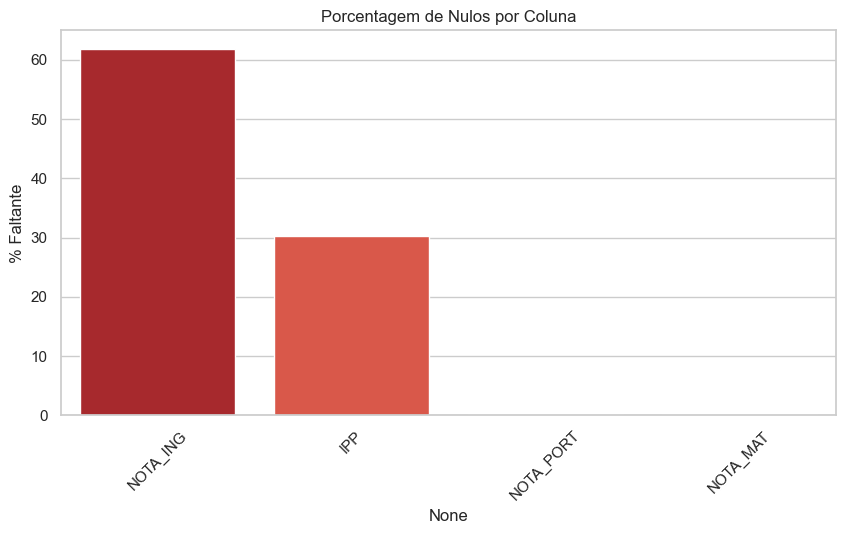

Colunas Críticas (>20% nulos):
['NOTA_ING', 'IPP']


In [5]:
# Configuração de Estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("=== 1. VISÃO GERAL DO DATASET ===")
print(f"Dimensões: {df_final.shape}")
display(df_final.head())

print("\n=== 2. ANÁLISE DE DADOS FALTANTES (NULOS) ===")
# Calcula % de nulos
nulos = df_final.isnull().sum() / len(df_final) * 100
nulos = nulos[nulos > 0].sort_values(ascending=False)

if not nulos.empty:
    plt.figure(figsize=(10, 5))
    
    # --- CORREÇÃO AQUI ---
    # Adicionamos hue=nulos.index e legend=False
    ax = sns.barplot(
        x=nulos.index, 
        y=nulos.values, 
        hue=nulos.index,  # A cor muda conforme a coluna (eixo X)
        legend=False,     # Não precisamos de legenda pois o eixo X já explica
        palette="Reds_r"
    )
    # ---------------------
    
    plt.title("Porcentagem de Nulos por Coluna")
    plt.ylabel("% Faltante")
    plt.xticks(rotation=45)
    plt.show()
    print("Colunas Críticas (>20% nulos):")
    print(nulos[nulos > 20].index.tolist())
else:
    print("Incrível! Zero nulos encontrados.")


=== 3. DISTRIBUIÇÃO DA VARIÁVEL ALVO (PEDRA) ===


PEDRA,Ametista,Quartzo,Topázio,Ágata
ANO_DATATHON,,,,
2022,348,132,130,250
2023,381,72,232,246
2024,391,112,326,225


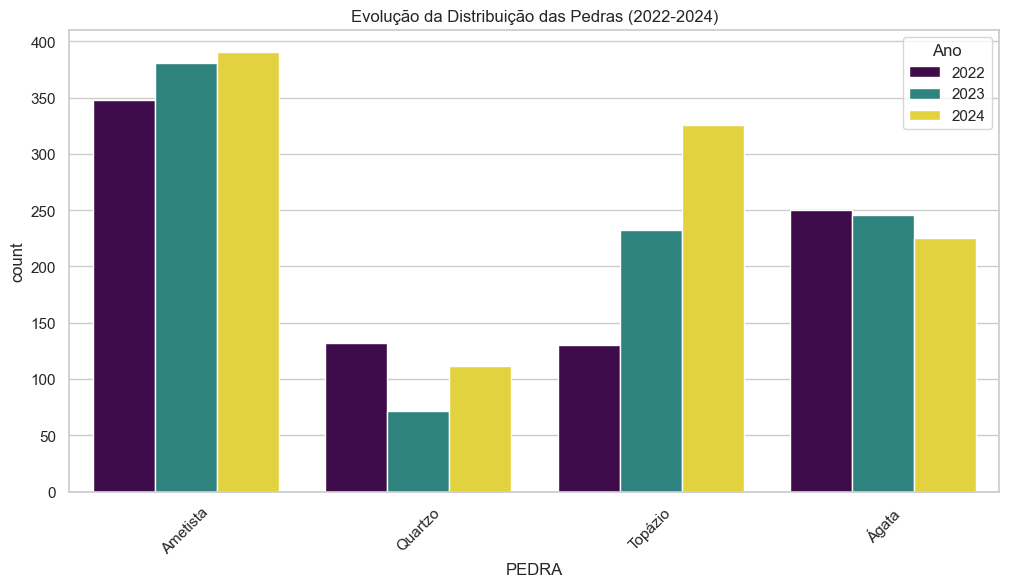

In [6]:
print("\n=== 3. DISTRIBUIÇÃO DA VARIÁVEL ALVO (PEDRA) ===")

# Tabela de Frequência
dist_pedra = df_final.groupby(['ANO_DATATHON', 'PEDRA']).size().unstack(fill_value=0)
display(dist_pedra)

# Gráfico
plt.figure(figsize=(12, 6))
sns.countplot(data=df_final, x='PEDRA', hue='ANO_DATATHON', palette='viridis', order=sorted(df_final['PEDRA'].dropna().unique()))
plt.title("Evolução da Distribuição das Pedras (2022-2024)")
plt.xticks(rotation=45)
plt.legend(title='Ano')
plt.show()


=== 4. MAPA DE CORRELAÇÃO ===


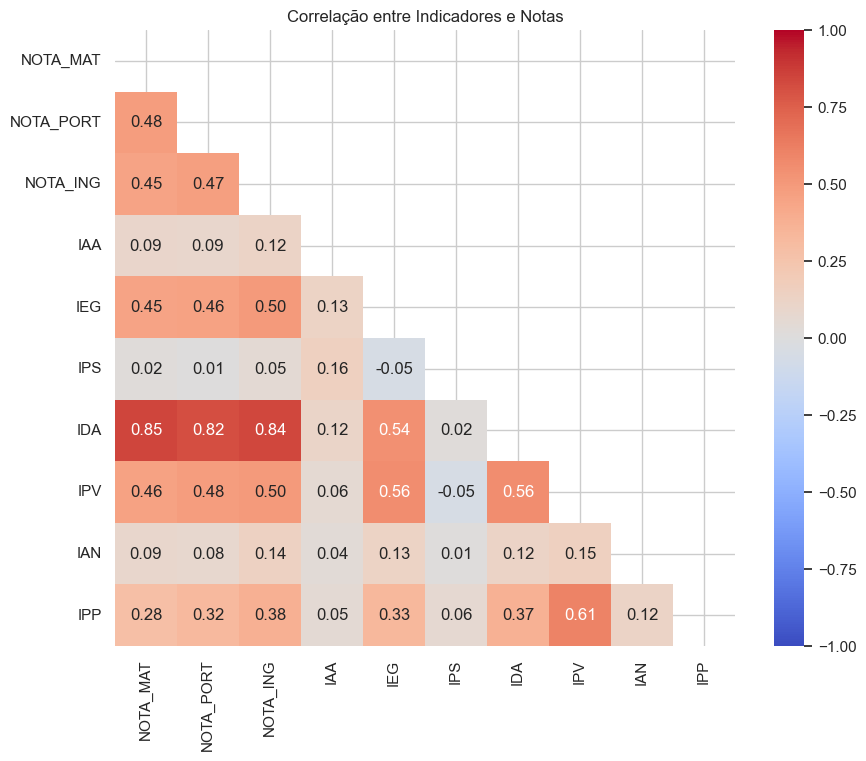

In [7]:
print("\n=== 4. MAPA DE CORRELAÇÃO ===")

# Selecionar apenas colunas numéricas relevantes
cols_numericas = ['NOTA_MAT', 'NOTA_PORT', 'NOTA_ING', 'IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN', 'IPP']
# Filtrar as que realmente existem no df
cols_corr = [c for c in cols_numericas if c in df_final.columns]

plt.figure(figsize=(10, 8))
corr_matrix = df_final[cols_corr].corr()

# Máscara para mostrar apenas a metade inferior (fica mais limpo)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlação entre Indicadores e Notas")
plt.show()

In [8]:
# --- BLOCO DE TRATAMENTO DE NULOS E REMOÇÃO DE REDUNDÂNCIA ---

# 1. Tratando o IPP (Preenchendo 2022 com a mediana geral para não perder a coluna)
# IPP é importante para o psicossocial, então mantemos e preenchemos falhas
mediana_ipp = df_final['IPP'].median()
df_final['IPP'] = df_final['IPP'].fillna(mediana_ipp)
print(f"Nulos de IPP preenchidos com a mediana: {mediana_ipp}")

# 2. Tratando Inglês (Criando flag e preenchendo com 0)
# Cria uma coluna para avisar o modelo: "Esse aluno tem aula de inglês?"
df_final['TEM_INGLES'] = df_final['NOTA_ING'].notnull().astype(int)
# Agora preenche a nota com 0 (seguro, pois a flag avisa que ele não tem aula)
df_final['NOTA_ING'] = df_final['NOTA_ING'].fillna(0)

# 3. Tratando Matemática e Português (Preenchendo falhas com a Mediana)
# Essas matérias são obrigatórias, nulo aqui é erro de cadastro.
for materia in ['NOTA_MAT', 'NOTA_PORT']:
    mediana_materia = df_final[materia].median()
    df_final[materia] = df_final[materia].fillna(mediana_materia)

# 4. Removendo o IDA (Decisão de Arquitetura)
# Removemos para evitar multicolinearidade, já que ele é redundante com as notas.
if 'IDA' in df_final.columns:
    df_final = df_final.drop(columns=['IDA'])
    print("Coluna 'IDA' removida com sucesso (Redundância).")

print("\nVerificação Final de Nulos (Deve estar tudo zerado):")
# Verificamos apenas as colunas que ficaram
cols_verificar = ['IPP', 'NOTA_ING', 'NOTA_MAT', 'NOTA_PORT', 'TEM_INGLES']
print(df_final[cols_verificar].isnull().sum())

Nulos de IPP preenchidos com a mediana: 7.5
Coluna 'IDA' removida com sucesso (Redundância).

Verificação Final de Nulos (Deve estar tudo zerado):
IPP           0
NOTA_ING      0
NOTA_MAT      0
NOTA_PORT     0
TEM_INGLES    0
dtype: int64


In [9]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2845 entries, 0 to 2927
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ANO_DATATHON  2845 non-null   int64  
 1   RA            2845 non-null   object 
 2   FASE          2845 non-null   object 
 3   GENERO        2845 non-null   object 
 4   IDADE         2845 non-null   object 
 5   ANO_INGRESSO  2845 non-null   int64  
 6   IAA           2845 non-null   float64
 7   IEG           2845 non-null   float64
 8   IPS           2845 non-null   float64
 9   IPV           2845 non-null   float64
 10  IAN           2845 non-null   float64
 11  IPP           2845 non-null   float64
 12  NOTA_MAT      2845 non-null   float64
 13  NOTA_PORT     2845 non-null   float64
 14  NOTA_ING      2845 non-null   float64
 15  FASE_IDEAL    2845 non-null   object 
 16  DEFASAGEM     2845 non-null   int64  
 17  PEDRA         2845 non-null   object 
 18  TEM_INGLES    2845 non-null   int

In [10]:
# Verificando os valores "sujos" na coluna IDADE
# O sort_values ajuda a colocar textos e números em ordem para facilitar a leitura

print("Valores únicos na coluna IDADE (Antes do tratamento):")
# Convertemos para string apenas para visualizar tudo junto, sem erro de sort
print(sorted(df_final['IDADE'].astype(str).unique()))

# Se quiser ver quantas vezes cada "sujeira" aparece:
print("\nContagem de valores (Top 20):")
print(df_final['IDADE'].value_counts().head(20))

Valores únicos na coluna IDADE (Antes do tratamento):
['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1900-01-07 00:00:00', '1900-01-08 00:00:00', '1900-01-09 00:00:00', '1900-01-10 00:00:00', '1900-01-11 00:00:00', '1900-01-12 00:00:00', '1900-01-13 00:00:00', '1900-01-14 00:00:00', '1900-01-15 00:00:00', '1900-01-16 00:00:00', '1900-01-17 00:00:00', '1900-01-18 00:00:00', '1900-01-19 00:00:00', '1900-01-20 00:00:00', '20', '21', '22', '7', '8', '9']

Contagem de valores (Top 20):
IDADE
10                     321
12                     316
11                     311
13                     268
9                      263
14                     235
15                     198
8                      180
16                     164
17                     129
1900-01-11 00:00:00     56
7                       47
1900-01-12 00:00:00     47
1900-01-09 00:00:00     43
1900-01-14 00:00:00     42
1900-01-10 00:00:00     36
18                      34
1900-01-08 00:00:00     34
1900-01

In [11]:
# --- ETAPA 1: CORREÇÃO CIRÚRGICA DA IDADE ---

# Primeiro, garantimos que tudo é string para analisar
df_final['IDADE'] = df_final['IDADE'].astype(str)

# Filtro para achar as datas do Excel (começam com "1900-")
mask_datas = df_final['IDADE'].str.startswith('1900-')

# Para essas linhas, convertemos para data e extraímos apenas o DIA
# Ex: "1900-01-11" vira 11
df_final.loc[mask_datas, 'IDADE'] = pd.to_datetime(df_final.loc[mask_datas, 'IDADE'], errors='coerce').dt.day

# Agora que convertemos as datas em dias, transformamos tudo em número
df_final['IDADE'] = pd.to_numeric(df_final['IDADE'], errors='coerce')

# Preenchemos eventuais nulos reais (agora devem ser poucos) com a mediana
mediana_idade = df_final['IDADE'].median()
df_final['IDADE'] = df_final['IDADE'].fillna(mediana_idade)

# --- VERIFICAÇÃO ---
print("Valores únicos de IDADE após correção:")
print(sorted(df_final['IDADE'].unique()))
print(f"\nTem algum nulo sobrando? {df_final['IDADE'].isnull().sum()}")

Valores únicos de IDADE após correção:
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

Tem algum nulo sobrando? 0


In [12]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2845 entries, 0 to 2927
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ANO_DATATHON  2845 non-null   int64  
 1   RA            2845 non-null   object 
 2   FASE          2845 non-null   object 
 3   GENERO        2845 non-null   object 
 4   IDADE         2845 non-null   int64  
 5   ANO_INGRESSO  2845 non-null   int64  
 6   IAA           2845 non-null   float64
 7   IEG           2845 non-null   float64
 8   IPS           2845 non-null   float64
 9   IPV           2845 non-null   float64
 10  IAN           2845 non-null   float64
 11  IPP           2845 non-null   float64
 12  NOTA_MAT      2845 non-null   float64
 13  NOTA_PORT     2845 non-null   float64
 14  NOTA_ING      2845 non-null   float64
 15  FASE_IDEAL    2845 non-null   object 
 16  DEFASAGEM     2845 non-null   int64  
 17  PEDRA         2845 non-null   object 
 18  TEM_INGLES    2845 non-null   int

In [13]:
# --- BLOCO DE ENCODING (TRANSFORMANDO TEXTO EM NÚMEROS) ---

# 1. PEDRA (Variável Alvo com Hierarquia)
# Criamos um dicionário para garantir que Topázio valha mais que Quartzo
mapa_pedra = {
    'Quartzo': 0,
    'Ágata': 1,
    'Ametista': 2,
    'Topázio': 3
}
# O map converte. O que não estiver na lista vira NaN (útil para achar erros)
df_final['PEDRA_NUM'] = df_final['PEDRA'].map(mapa_pedra)

# 2. GÊNERO (Binário)
# Padroniza variações de escrita e transforma em 0 ou 1
mapa_genero = {
    'Feminino': 1, 'Menina': 1,
    'Masculino': 0, 'Menino': 0
}
df_final['GENERO_NUM'] = df_final['GENERO'].map(mapa_genero)

# 3. FASE (Extração Numérica)
# A fase vem como "Fase 1 (4o ano)". O modelo precisa só do "1".
# Usamos REGEX (Expressão Regular) para pegar apenas os dígitos
df_final['FASE_NUM'] = df_final['FASE'].astype(str).str.extract(r'(\d+)').astype(float)
# Se der erro ou vazio, preenche com 0
df_final['FASE_NUM'] = df_final['FASE_NUM'].fillna(0)

# --- VERIFICAÇÃO E CORRELAÇÃO ---
print("Transformação concluída!")
print(f"Colunas criadas: PEDRA_NUM, GENERO_NUM, FASE_NUM")

# Vamos ver se deu certo?
# Se a 'NOTA_MAT' tiver correlação POSITIVA alta com 'PEDRA_NUM',
# significa que o modelo entendeu que Notas Altas = Pedras Melhores (3)
correlacao = df_final.corr(numeric_only=True)['PEDRA_NUM'].sort_values(ascending=False)

print("\n--- O que mais influencia a Pedra? (Correlação) ---")
print(correlacao.head(10))

Transformação concluída!
Colunas criadas: PEDRA_NUM, GENERO_NUM, FASE_NUM

--- O que mais influencia a Pedra? (Correlação) ---
PEDRA_NUM    1.000000
IEG          0.694958
IPV          0.666839
NOTA_MAT     0.619980
NOTA_PORT    0.603866
IPP          0.417965
DEFASAGEM    0.402304
IAN          0.392179
IAA          0.374667
IPS          0.190742
Name: PEDRA_NUM, dtype: float64


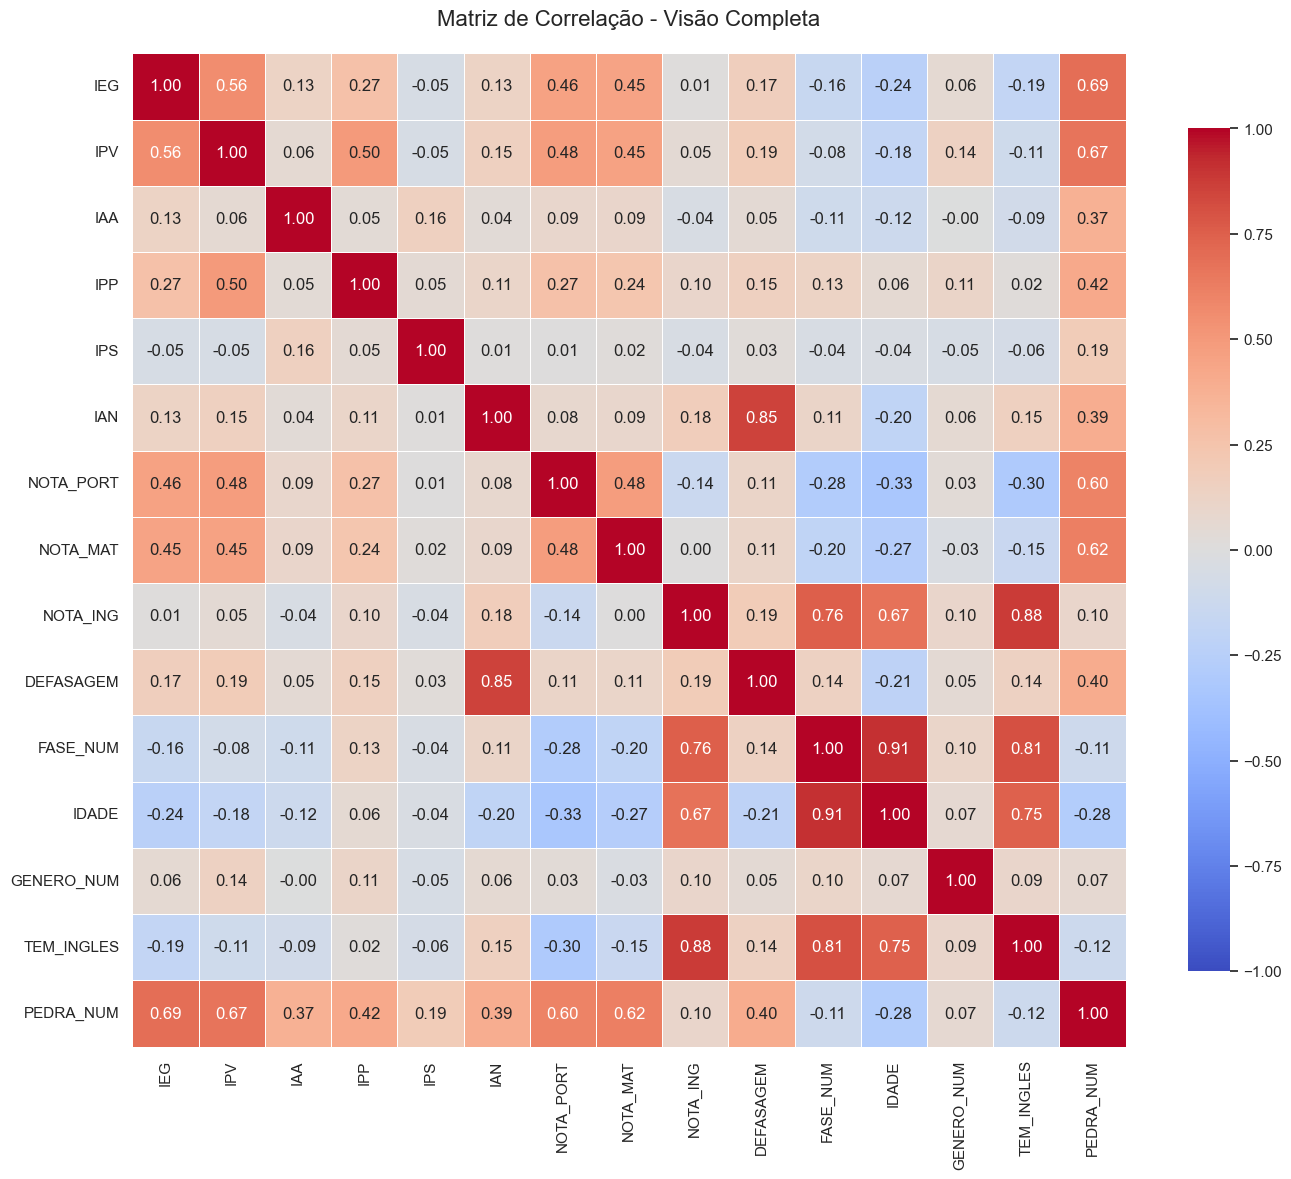

In [14]:
# --- BLOCO DE VISUALIZAÇÃO GERAL (ANÁLISE PRÉ-MODELAGEM) ---
import matplotlib.pyplot as plt
import seaborn as sns
import math

# 1. Definindo as variáveis que entrarão no modelo
# (Certifique-se que todas essas colunas existem no seu df_final)
cols_analise = [
    'IEG', 'IPV', 'IAA', 'IPP', 'IPS', 'IAN',       # Indicadores
    'NOTA_PORT', 'NOTA_MAT', 'NOTA_ING',            # Notas
    'DEFASAGEM', 'FASE_NUM', 'IDADE', 'GENERO_NUM', # Contexto
    'TEM_INGLES', 'PEDRA_NUM'                       # Target e Flags
]

# Filtrar apenas as que existem (segurança contra erros de digitação)
cols_existentes = [c for c in cols_analise if c in df_final.columns]

# --- A. GRÁFICO DE CORRELAÇÃO COMPLETO ---
plt.figure(figsize=(14, 12))
plt.title("Matriz de Correlação - Visão Completa", fontsize=16, pad=20)

# Calculando correlação (numeric_only=True garante que só pega números)
corr = df_final[cols_existentes].corr(numeric_only=True)

# Plotando o Heatmap (sem máscara, quadrado inteiro)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})

plt.tight_layout()
plt.show()

C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_40736\2717403356.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final, x='PEDRA_NUM', y=col, palette='viridis', ax=ax)
C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_40736\2717403356.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([labels_pedra.get(x, x) for x in sorted(df_final['PEDRA_NUM'].unique())])
C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_40736\2717403356.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final, x='PEDRA_NUM', y=col, palette='viridis', ax=ax)
C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_4

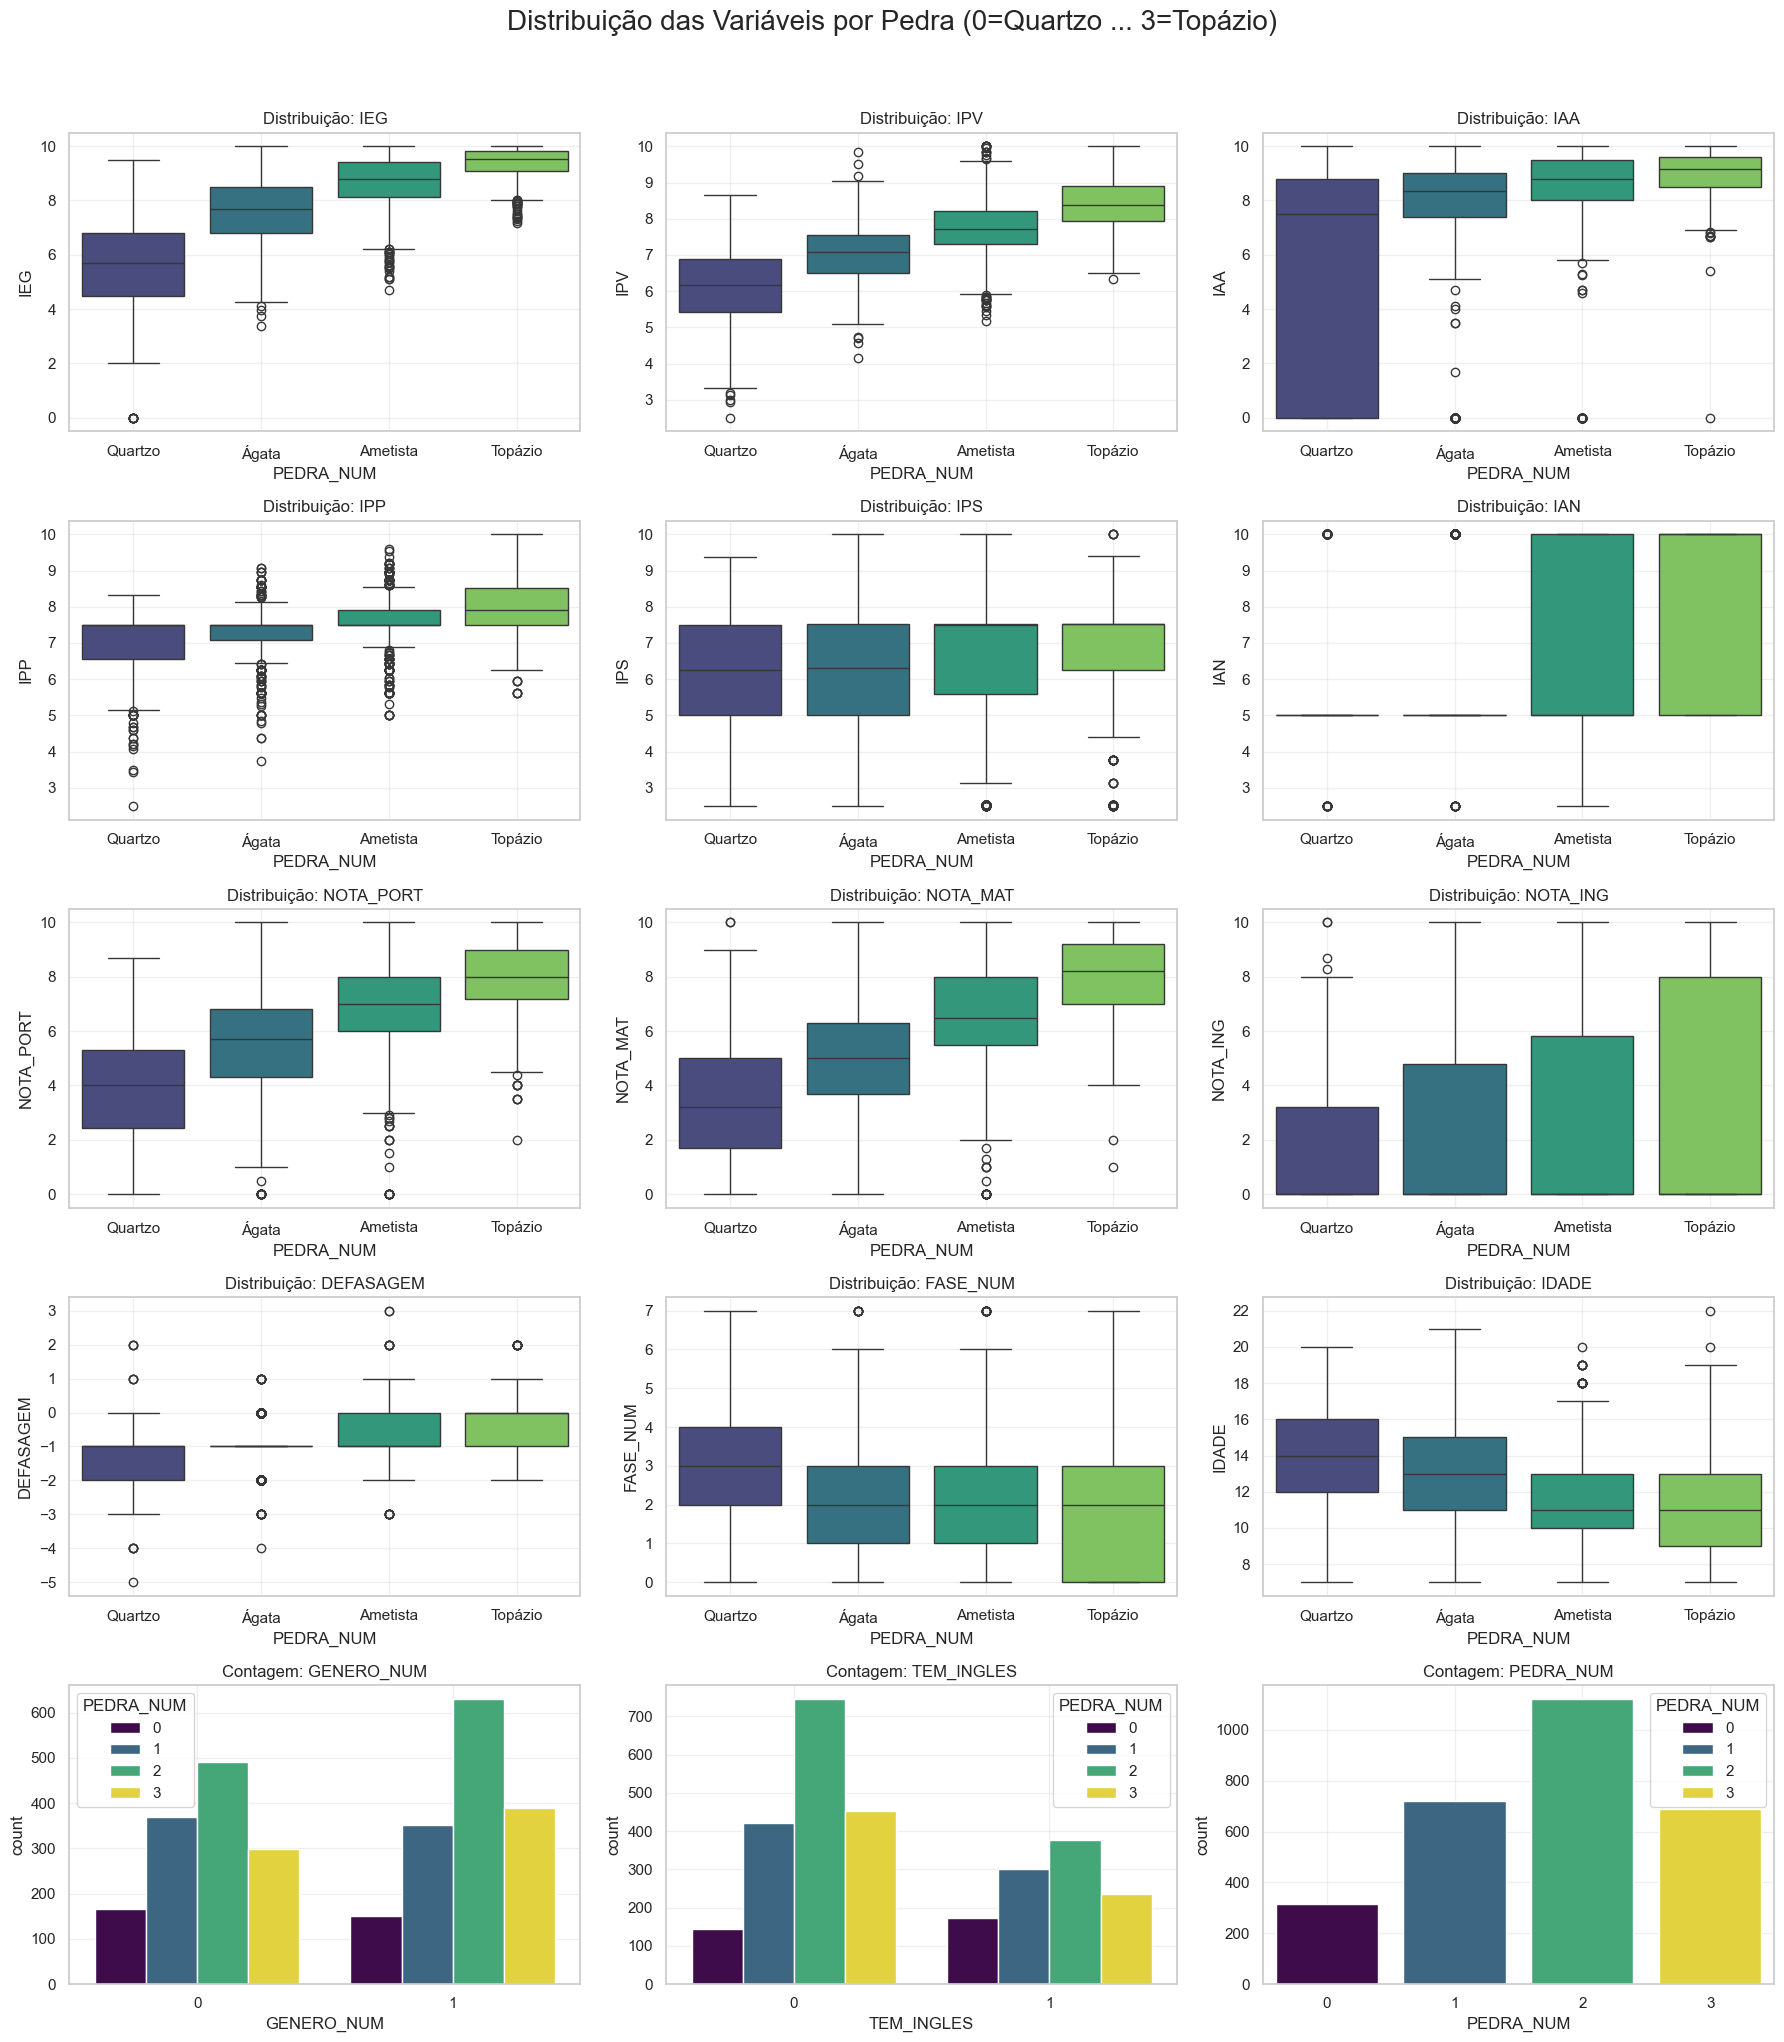

In [15]:
# --- B. BOXPLOTS DE TODAS AS VARIÁVEIS (Cruzando com a Pedra) ---
# Vamos criar um grid dinâmico de gráficos
num_vars = len(cols_existentes)
cols_grid = 3  # 3 gráficos por linha
rows_grid = math.ceil(num_vars / cols_grid)

plt.figure(figsize=(18, rows_grid * 4)) # Altura ajustável baseada na quantidade
plt.suptitle("Distribuição das Variáveis por Pedra (0=Quartzo ... 3=Topázio)", fontsize=20, y=1.02)

# Mapeamento para os rótulos do eixo X ficarem bonitos
labels_pedra = {0: 'Quartzo', 1: 'Ágata', 2: 'Ametista', 3: 'Topázio'}

for i, col in enumerate(cols_existentes):
    ax = plt.subplot(rows_grid, cols_grid, i + 1)
    
    # Se for a própria pedra ou gênero, fazemos um countplot (barra) em vez de boxplot
    if col in ['PEDRA_NUM', 'GENERO_NUM', 'TEM_INGLES']:
        sns.countplot(data=df_final, x=col, hue='PEDRA_NUM', palette='viridis', ax=ax)
        ax.set_title(f"Contagem: {col}")
    else:
        # Boxplot normal para variáveis contínuas
        sns.boxplot(data=df_final, x='PEDRA_NUM', y=col, palette='viridis', ax=ax)
        ax.set_title(f"Distribuição: {col}")
        
        # Ajusta os labels do eixo X para mostrar os nomes das pedras
        ax.set_xticklabels([labels_pedra.get(x, x) for x in sorted(df_final['PEDRA_NUM'].unique())])

    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

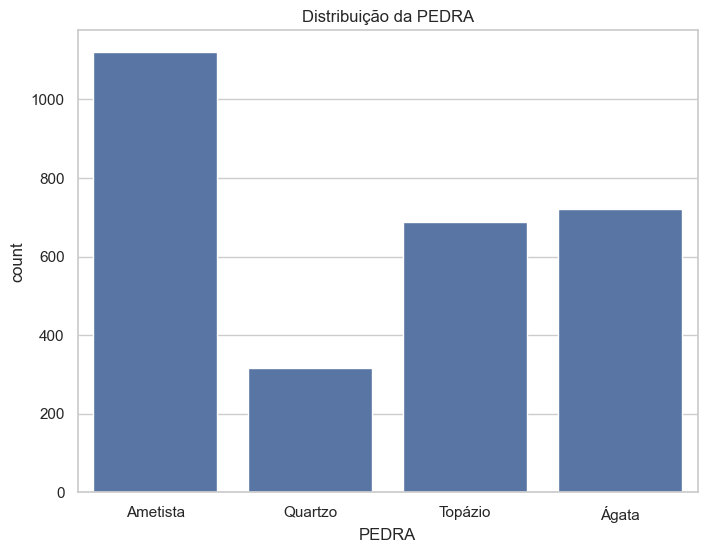

In [16]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_final, x='PEDRA', order=sorted(df_final['PEDRA'].unique()))
plt.title('Distribuição da PEDRA')
plt.show()